# Speech Augmentations

In this seminar, we will learn basic augmentations for speech.

    1) Gaussian Noise
    2) Time Stretching
    3) Pitch Shifting
    4) Volume
    5) Impulse Response
    6) Add Noise on Background
    7) SpecAug (Time/Freq masking, Cutout)

Also pay attention on `SpeechBrain` library which contain a lot of useful stuff including [speech augumentation](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.processing.speech_augmentation.html#speechbrain.processing.speech_augmentation.AddBabble)

---

In [1]:
from IPython import display
from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
import torchaudio

import librosa

In [2]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr, normalize=False))

In [5]:
wav, sr = torchaudio.load('LJ001-0001.wav')

# Ground Truth 

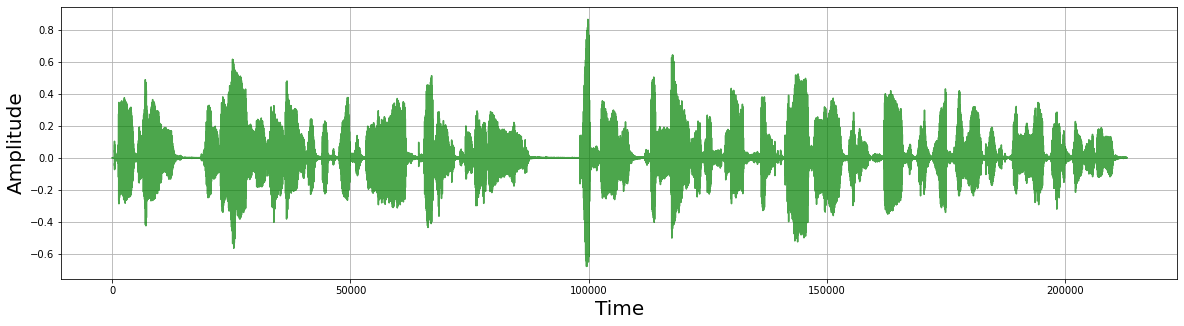

TypeError: ignored

In [6]:
visualize_audio(wav)

# Gaussian Noise

A very simple augmentation that appears in various areas of machine learning.

In [7]:
from torch import distributions

In [8]:
noiser = distributions.Normal(0, 0.05)

In [9]:
augumented_wav_1 = wav + noiser.sample(wav.size())

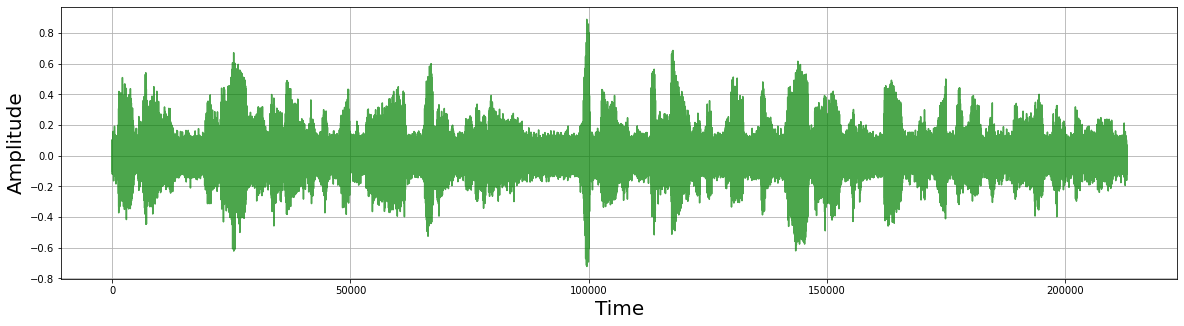

TypeError: ignored

In [10]:
visualize_audio(augumented_wav_1)

# Time Stretching

This augmentation speeds up or slows down the speed of speech. For more information, visit https://www.dafx.de/paper-archive/2000/pdf/Bernardini.pdf.

There are two ways to do `Time Stretching`:

1) Use `librosa.effects.time_stretch` from `librosa` which works with `wav`s

2) Use `torchaudio.transforms.TimeStretch` from `torchaudio` which works with `spectrogram`s.
In this case, we additionally need to use STFT and iSTFT (inverse STFT)

In [11]:
augumented_wav_2 = librosa.effects.time_stretch(wav.numpy().squeeze(), 0.7)
augumented_wav_2 = torch.from_numpy(augumented_wav_2)

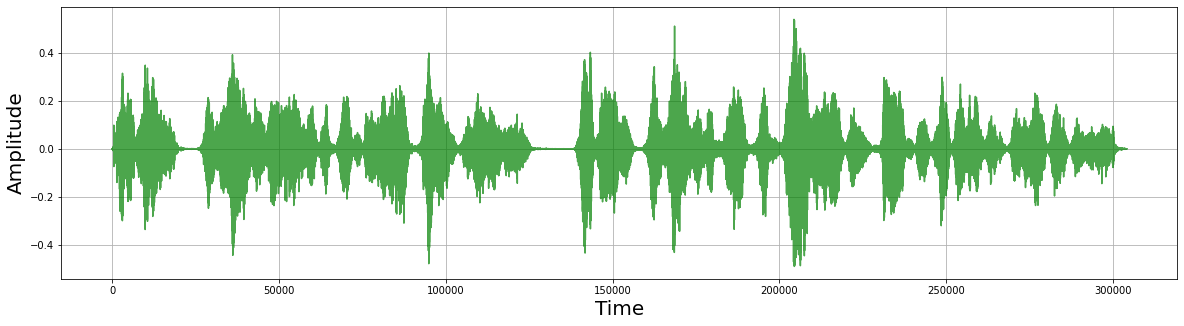

TypeError: ignored

In [12]:
visualize_audio(augumented_wav_2)

# Pitch Shifting

This augmentation changes the pitch of voice. For example, it makes the voice more "heavy". Similarly, for more information, visit https://www.dafx.de/paper-archive/2000/pdf/Bernardini.pdf.

In [13]:
augumented_wav_3 = librosa.effects.pitch_shift(wav.numpy().squeeze(), sr, -5)
augumented_wav_3 = torch.from_numpy(augumented_wav_3)

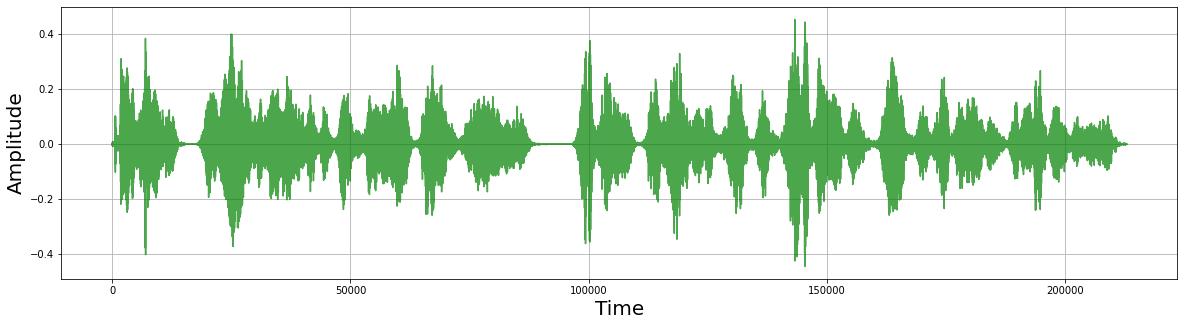

TypeError: ignored

In [14]:
visualize_audio(augumented_wav_3)

# Volume

This augmentation changes level of volume. It seems like simple augmentation but in some cases it could help :)

In [15]:
voler = torchaudio.transforms.Vol(gain=.2, gain_type='amplitude')

In [16]:
augumented_wav_4 = voler(wav)

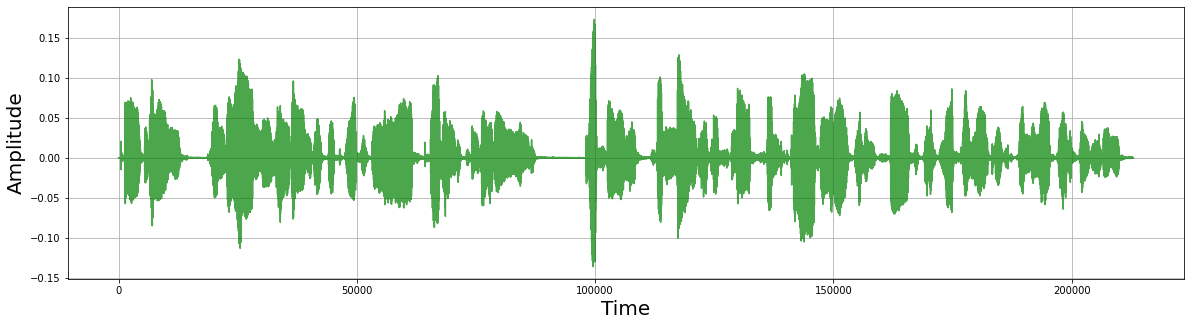

TypeError: ignored

In [17]:
visualize_audio(augumented_wav_4)

# Room Impulse Response

This augmentation convolves an audio signal with an impulse response. As result, we simulate new enviroment acoustic on given audio.

It may be a little bit trickly, so feel free to learn more about it:

    1) https://www.acousticalsurfaces.com/acoustic_IOI/reverberation.htm
    2) https://www.sonic-shield.com/echo-vs-reverberation
    3) https://en.wikipedia.org/wiki/Convolution_reverb
    4) https://danielpovey.com/files/2017_icassp_reverberation.pdf

In [18]:
rir, rir_sr = torchaudio.load('h001_Bedroom_65.wav')

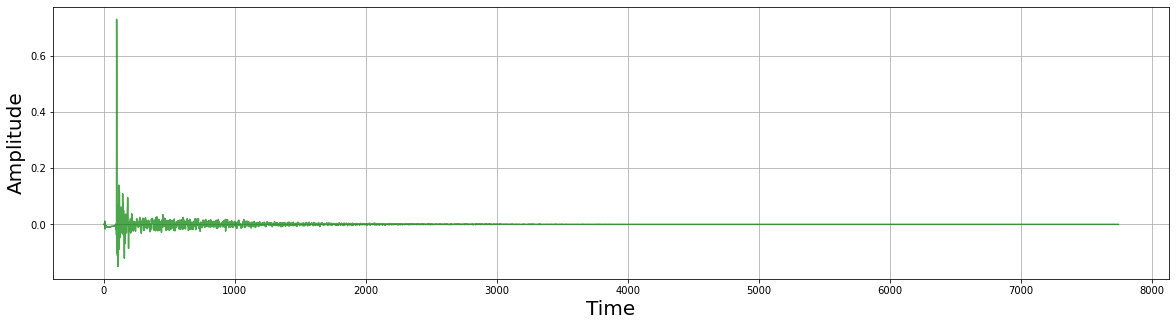

TypeError: ignored

In [19]:
visualize_audio(rir, rir_sr)

In [20]:
def simulate(audio: torch.Tensor, rir: torch.Tensor):
    left_pad = right_pad = rir.shape[-1] - 1
    
    # Since torch.conv do cross-correlation (not convolution) we need to flip kernel
    flipped_rir = rir.squeeze().flip(0)

    audio = F.pad(audio, [left_pad, right_pad]).view(1, 1, -1)
    convolved_audio = torch.conv1d(audio, flipped_rir.view(1, 1, -1)) \
        .squeeze()
    
    # peak normalization
    if convolved_audio.abs().max() > 1:
        convolved_audio /= convolved_audio.abs().max()

    return convolved_audio

In [21]:
augumented_wav_5 = simulate(wav, rir)

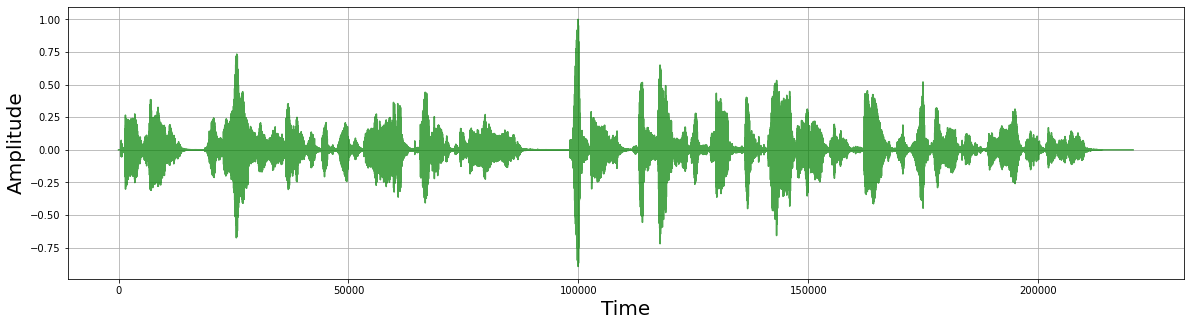

TypeError: ignored

In [22]:
visualize_audio(augumented_wav_5)

# Add noise audio on background

Let's imagine that we have a lot of samples of noises. For example, sound of street, car, talk an so on. Then we would like to add such noise to the background so that the model (for example, ASR) would be more robust to them.

There is a rule of thumb on how to properly add noise to the background:

    1) https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
    2) https://arxiv.org/pdf/1808.00563.pdf (3.1 chapter)

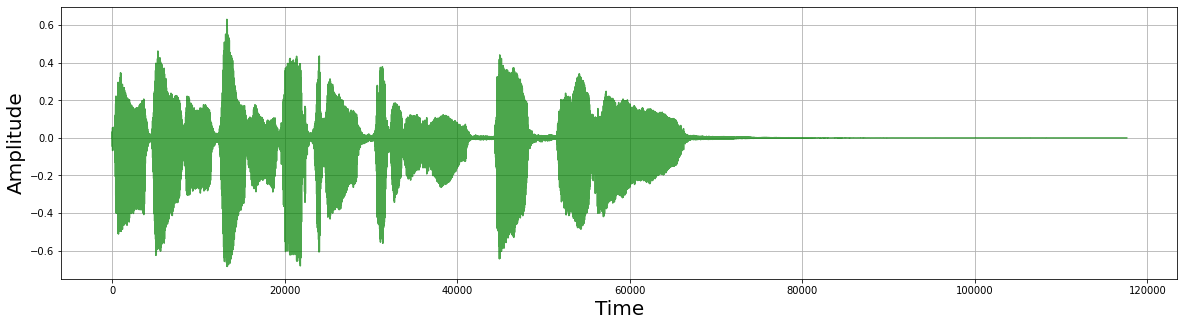

TypeError: ignored

In [23]:
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename)

noise = y

visualize_audio(torch.from_numpy(noise))

In [ ]:
noize_level = torch.Tensor([20])  # [0, 40]

noize_energy = torch.norm(torch.from_numpy(noise))
audio_energy = torch.norm(wav)

alpha = (audio_energy / noize_energy) * torch.pow(10, -noize_level / 20)

clipped_wav = wav[..., :noise.shape[0]]

augumented_wav_6 = clipped_wav + alpha * torch.from_numpy(noise)

# In some cases the resulting sound may go beyond [-1, 1]
# So, clamp it :)
augumented_wav_6 = torch.clamp(augumented_wav_6, -1, 1)

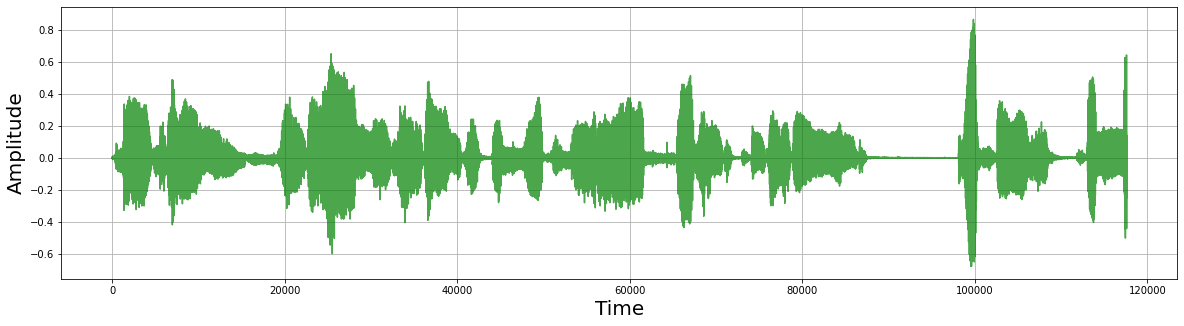

In [ ]:
visualize_audio(augumented_wav_6)

# SpecAug (Time/Freq masking, Cutout)

As we already know, main type of “features" in speech processing is (Mel)Spectrogram. From a practical point of view Spectrogram is image, so we сould apply some ideas from Computer Vision. `SpecAug` motivation come from it. 

For more details, please, visit: https://arxiv.org/pdf/1904.08779.pdf

In [ ]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)

mel_spectrogram = mel_spectrogramer(wav)
log_mel_spectrogram = torch.log(mel_spectrogram).squeeze()

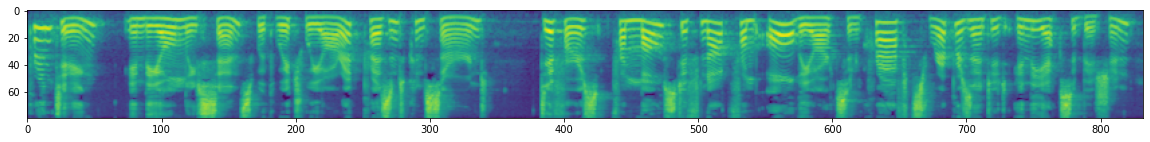

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(log_mel_spectrogram)
plt.show()

`torchaudio.transforms.FrequencyMasking` add horizontal strip and `torchaudio.transforms.TimeMasking` add vertical strip.

Note that this is one way to implement SpecAug. In practice, you may encounter different implementations.

In [ ]:
specaug = nn.Sequential(
    torchaudio.transforms.FrequencyMasking(20),
    torchaudio.transforms.TimeMasking(100),
)

In [ ]:
augumented_log_mel_spectrogram = specaug(log_mel_spectrogram)

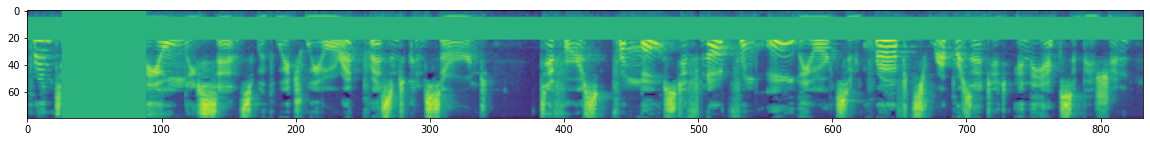

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(augumented_log_mel_spectrogram)
plt.show()